# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# Checking to see if directories on my Google Drive are accessible
!ls '/content/gdrive/My Drive/CS231n'

Assignment_1  Assignment_2


In [3]:
# Changing the current working directory of current Jupyter notebook to be directory which includes im2col_cython.pyx 
# and setup.py files so that im2col_cython.pyx can be compiled to im2col_cython.pyd file which can then be imported
# as from im2col_cython import * to access all functions contained in im2col_cython.pyd
import os
os.chdir('/content/gdrive/My Drive/CS231n/Assignment_2/cs231n')


!ls

build					       im2col_cython.pyx
classifiers				       im2col.py
datasets				       __init__.py
data_utils.py				       layers.py
fast_layers.py				       layer_utils.py
fc_net.py				       optim.py
gradient_check.py			       __pycache__
im2col_cython.c				       setup.py
im2col_cython.cpython-36m-x86_64-linux-gnu.so  solver.py
im2col_cython.pyd			       vis_utils.py


In [0]:
# Trying to import python modules from files stored on my Google Drive
# Following example here: http://www.pingshiuanchua.com/blog/post/importing-your-own-python-module-or-python-file-in-colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt

fc_net_module = drive.CreateFile({'id':'1qW4tRfXsIx2hbwShrTyonhJAywcDhz3R'})
fc_net_module.GetContentFile('fc_net.py')

#from cs231n.classifiers.fc_net import *
from fc_net import *

data_utils_module = drive.CreateFile({'id':'144um0xYAt6S_1CVec91aUKykEs-1iS0U'})
data_utils_module.GetContentFile('data_utils.py')

#from cs231n.data_utils import get_CIFAR10_data
from data_utils import get_CIFAR10_data

gradient_check_module = drive.CreateFile({'id':'1HjMjoLB0kCtG279M05gkVs9Wd03GtlFk'})
gradient_check_module.GetContentFile('gradient_check.py')

#from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from gradient_check import eval_numerical_gradient, eval_numerical_gradient_array

solver_module = drive.CreateFile({'id':'1hqWw2ugRv_urseN8Xp0hf2V6ahAVjurp'})
solver_module.GetContentFile('solver.py')

#from cs231n.solver import Solver
from solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [6]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [7]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



# Dropout backward pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [8]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

## Answer:
If we do not divide by $p$ in the dropout layer (i.e., perform vanilla dropout), the outputs of neurons at test time would not be identical to their expected outputs at training time.  To see this, consider an output of a neuron $x$ before dropout. With dropout, the expected output from this neuron will become $p*x + (1-p)*0$ because the neuron’s output will be set to zero with probability $1−p$. At test time, when we always keep the neuron active, we must then adjust $x$ to $p*x$ in order to keep the same expected output.

# Fully-connected nets with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specifically, if the constructor of the net receives a value that is not 1 for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [9]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout=1 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.75
Initial loss:  2.302371489704412
W1 relative error: 1.90e-07
W2 relative error: 4.76e-06
W3 relative error: 2.60e-08
b1 relative error: 4.73e-09
b2 relative error: 1.82e-09
b3 relative error: 1.70e-10

Running check with dropout =  0.5
Initial loss:  2.3042759220785896
W1 relative error: 3.11e-07
W2 relative error: 1.84e-08
W3 relative error: 5.35e-08
b1 relative error: 5.37e-09
b2 relative error: 2.99e-09
b3 relative error: 1.13e-10



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [10]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

1
(Iteration 1 / 125) loss: 7.856643
(Epoch 0 / 25) train acc: 0.260000; val_acc: 0.184000
(Epoch 1 / 25) train acc: 0.416000; val_acc: 0.258000
(Epoch 2 / 25) train acc: 0.482000; val_acc: 0.276000
(Epoch 3 / 25) train acc: 0.532000; val_acc: 0.277000
(Epoch 4 / 25) train acc: 0.600000; val_acc: 0.271000
(Epoch 5 / 25) train acc: 0.708000; val_acc: 0.299000
(Epoch 6 / 25) train acc: 0.722000; val_acc: 0.282000
(Epoch 7 / 25) train acc: 0.832000; val_acc: 0.255000
(Epoch 8 / 25) train acc: 0.878000; val_acc: 0.269000
(Epoch 9 / 25) train acc: 0.902000; val_acc: 0.275000
(Epoch 10 / 25) train acc: 0.888000; val_acc: 0.261000
(Epoch 11 / 25) train acc: 0.926000; val_acc: 0.278000
(Epoch 12 / 25) train acc: 0.960000; val_acc: 0.302000
(Epoch 13 / 25) train acc: 0.964000; val_acc: 0.305000
(Epoch 14 / 25) train acc: 0.966000; val_acc: 0.309000
(Epoch 15 / 25) train acc: 0.976000; val_acc: 0.288000
(Epoch 16 / 25) train acc: 0.988000; val_acc: 0.301000
(Epoch 17 / 25) train acc: 0.988000; v

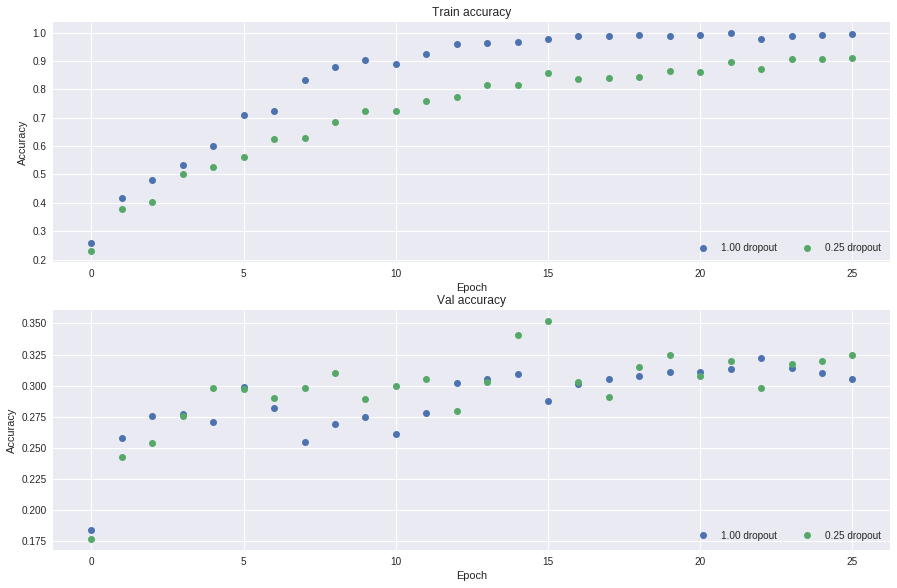

In [11]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:
Whereas the model without dropout attains 100% training accuracy (suggestive of significant overfitting, especially since the same model attains ~30% validation accuracy), the model with dropout displays less overfitting (~90% training accuracy and a slightly higher validation accuracy than the model without dropout).  This result suggests that dropout functions as a regularizer, meaning that it reduces model overfitting (at least a little bit).

## Inline Question 3:
Suppose we are training a deep fully-connected network for image classification, with dropout after hidden layers (parameterized by keep probability p). How should we modify p, if at all, if we decide to decrease the size of the hidden layers (that is, the number of nodes in each layer)?

## Answer:
If the number of nodes in each layer is decreased, then the keep probability $p$ should be increased if the goal is to keep essentially the same number of active neurons in the neural network.  Empirically, this is shown to improve classification error at training time and test time in the initial paper which proposed dropout (see original paper at https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf, with specific reference to Figure 9b).